In [1]:
from utils import *
import spotipy
import pickle
import numpy as np
from spotipy import SpotifyClientCredentials, util
from IPython.core.display import clear_output

import pandas as pd 
import time
import sqlite3

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Download all the data on my preference

In [4]:
playlist_data = []
playlists_use = ['https://open.spotify.com/playlist/2TQQnaW2uK04hfhkU6bq3F?si=af442323cf1d4f37',
                 'https://open.spotify.com/playlist/70COnLTVsTFknPKshNchBH?si=2866855ed876478b',
                 'https://open.spotify.com/playlist/1afrYKriM13xb3ntt9JPpm?si=adc6f696784e427f',
                 'https://open.spotify.com/playlist/4qfXTzKFl3QXKtrSTLsJoL?si=7518e358b5b64c08&pt=0c95f8e6b3ba6e718785dc57c4717e8f',
                 'https://open.spotify.com/playlist/27lYnKkfehRSszPUbDcXFB?si=a67b6088ed6e4ce7',
                 'https://open.spotify.com/playlist/1z2S6QKn1p1hkQweFExYx6?si=fea8a5ff0dba47bc',
                 'https://open.spotify.com/playlist/0nsXKn08HWZQAyk5cOSskd?si=a8249ef08c1d4aa0']
for playlist in playlists_use:
    tracks, columns = download_playlist(playlist, 1)
    playlist_data.append(pd.DataFrame(tracks, columns=columns))
playlist_data = pd.concat(playlist_data)


In [5]:
# music I don't like
playlist_data_dislike = []
playlists_use_dislike = ['https://open.spotify.com/playlist/37i9dQZF1DWWvvyNmW9V9a?si=63e1990c92b7403e',
                         'https://open.spotify.com/playlist/37i9dQZF1DX4dyzvuaRJ0n?si=ab23d5e4d74e452d',
                         'https://open.spotify.com/playlist/37i9dQZF1DX9wa6XirBPv8?si=84cf1adc71b54615']
for playlist in playlists_use_dislike:
    tracks, columns = download_playlist(playlist, 1)
    playlist_data_dislike.append(pd.DataFrame(tracks, columns=columns))
playlist_data_dislike = pd.concat(playlist_data_dislike)


In [6]:
playlist_data['label'] = 'like'
playlist_data_dislike['label'] = 'dislike'
playlist_data_all = pd.concat([playlist_data, playlist_data_dislike])
playlist_data_all.to_csv('my-music-preference.csv')

# Cluster my preference to check for seperation

In [2]:
playlist_data = pd.read_csv('my-music-preference.csv', index_col=0)
playlist_data.head(5)

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,label
0,Breakdown,Tom Petty & The Heartbreakers,Tom Petty and the Heartbreakers,5x53pbGk6sbl1BGom19QQ5,1976-11-09,62,163893,0.625,0.3980,0.350,0.000068,0.1230,0.690,-8.395,0.0436,113.688,9,4,like
1,Tenth Avenue Freeze-Out,Born To Run,Bruce Springsteen,4Gmdm6oRVwJgsM8gYnwRoE,1975-08-25,57,190466,0.702,0.4820,0.777,0.000000,0.0789,0.918,-4.446,0.0347,116.819,2,4,like
2,Stop Draggin' My Heart Around (with Tom Petty ...,Bella Donna,Stevie Nicks,15t8oEqZExdyesPVVKcxTd,1981,0,242760,0.629,0.3130,0.587,0.002580,0.1250,0.634,-7.228,0.0260,107.068,4,4,like
3,Blinded By The Light,"Greetings from Asbury Park, N.J.",Bruce Springsteen,1VyDQtfhX6gqhWTGU7Oe8X,1973-01-05,46,304440,0.498,0.2300,0.831,0.000000,0.3620,0.771,-6.973,0.1890,127.610,4,4,like
4,"Paint It, Black - (Original Single Mono Version)",Singles 1965-1967,The Rolling Stones,7lY8aoN3wUR3NY4nUwigPv,2004-07-12,51,224133,0.496,0.0135,0.859,0.065000,0.3490,0.768,-7.927,0.0934,159.694,5,4,like


In [3]:
use_clust = playlist_data.columns[playlist_data.dtypes != 'object']
X_train = MinMaxScaler().fit_transform(playlist_data[use_clust])
pca = PCA(n_components=3)
pca.fit(X_train)
# save
with open('my-music-preference-pca.pkl','wb') as f:
    pickle.dump(pca,f)

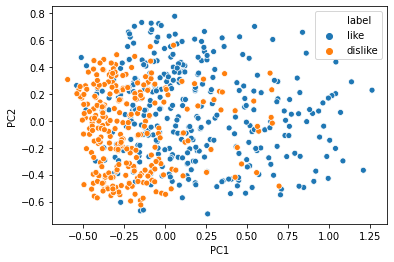

In [4]:
dim_me = pd.DataFrame(pca.transform(X_train))
dim_me.columns = ['PC1','PC2', 'PC3']
dim_me['status'] = 'me'
dim_me['name'] = playlist_data['name'].values
dim_me['label'] = playlist_data['label'].values
dim_me.to_csv('my-music-preference-pca.csv')
sns.scatterplot('PC1','PC2', data=dim_me, hue='label')
plt.show()


/Users/cameronmartino/miniconda2/envs/qiime2-2019.7/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


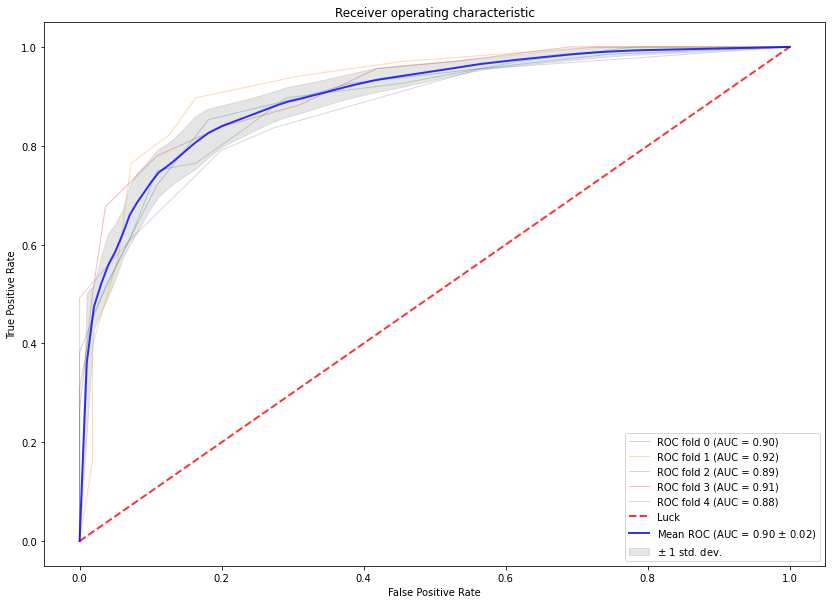

,AUC Train,AUC Test
0,0.999723,0.896390
1,0.999614,0.920053
2,0.999514,0.891845
3,0.999782,0.913636
4,0.999499,0.875712


In [5]:
clf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
X = playlist_data[use_clust].copy()
y = playlist_data['label'].replace('like', 1).replace('dislike', 0).copy()
for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[train], y.iloc[train])
    y_predict = clf.predict_proba(X.iloc[train])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[train], y_predict)
    auc_score_train = auc(fpr, tpr)
    #_, _, auc_score_train = compute_roc_auc(clf, train)
    #fpr, tpr, auc_score = compute_roc_auc(test)
    y_predict = clf.predict_proba(X.iloc[test])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[test], y_predict)
    auc_score = auc(fpr, tpr)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [6]:
feat_imp = pd.DataFrame(pca.components_, ['PC1','PC2', 'PC3'], use_clust).T.sort_values('PC1')
feat_imp

,PC1,PC2,PC3
energy,-0.545705,-0.015308,0.109676
popularity,-0.352396,-0.267548,-0.488388
loudness,-0.274592,-0.031233,0.005374
tempo,-0.167626,-0.156944,-0.204147
key,-0.118667,0.896957,-0.412948
valence,-0.098395,0.138432,0.501735
danceability,-0.063915,0.202657,0.368349
speechiness,-0.058317,0.189027,0.317243
instrumentalness,-0.051517,-0.033127,-0.094827
time_signature,-0.037386,0.007979,0.027810


# Download this weeks ML songs

In [2]:
ml_week = 'https://open.spotify.com/playlist/4JsC13qNckuUILFozVLk9h?si=0c34f0f4950547e0'
tracks, columns = download_playlist(ml_week, 100)
ml_week_score = pd.DataFrame(tracks, columns=columns)
ml_week_score.head(5)

Music Downloaded!


,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature
0,Last Year's Wife,Last Year's Wife - The Collection,Zero Le Creche,0py1EFcr09sIP0HApzH8qc,2008-01-21,0,233266,0.503,0.00469,0.724,0.000408,0.107,0.444,-9.941,0.0377,148.069,2,4
1,Five Four You Are,Blue June,Blue June,0QVmXEVAIBGVDsVZzIoSIM,2020-07-03,5,301572,0.297,0.00644,0.843,0.611000,0.112,0.503,-9.027,0.0294,102.469,5,3
2,Vacuum Cleaner,The Psychedelic Scene,Various Artists,1AOk8SIRVXiYip7rSmjp8m,1998-01-01,16,184493,0.332,0.07610,0.697,0.000213,0.101,0.763,-9.838,0.0641,103.918,9,4
3,New Speedway Boogie,New Speedway Boogie,Jabbawaukee,49EdQKFEShJp7YIdBZRsAN,2023-07-22,1,340163,0.662,0.00351,0.591,0.000276,0.104,0.742,-11.764,0.0551,93.128,11,4
4,Sweetest Touch,Teen Jamz,Gross Magic,4CWNlLaZk6c78sYpqfZqDE,2011,11,208000,0.339,0.07320,0.672,0.059400,0.138,0.304,-5.365,0.0840,170.572,5,4


In [3]:
# drop "my song" so not in score
mysong = 'Certified'
ml_week_score = ml_week_score[ml_week_score.name != 'Certified']

# Score compared to my preference

In [4]:
# load my pref.
with open('my-music-preference-pca.pkl', 'rb') as f:
    pca = pickle.load(f)
# use the same features and order (if not already imported above...)
playlist_data = pd.read_csv('my-music-preference.csv', index_col=0)
use_clust = playlist_data.columns[playlist_data.dtypes != 'object']
X_test = MinMaxScaler().fit_transform(ml_week_score[use_clust])
# project new data
new_ml = pd.DataFrame(pca.transform(X_test))
new_ml.columns = ['PC1','PC2', 'PC3']
new_ml['status'] = 'ml'
new_ml['label'] = 'ML'
new_ml['name'] = ml_week_score['name']
dim_me = pd.read_csv('my-music-preference-pca.csv', index_col=0)
all_to_score = pd.concat([new_ml, dim_me], axis=0, sort=False).set_index('name')
all_to_score.head(5)

,PC1,PC2,PC3,status,label
name,,,,,
Last Year's Wife,0.120434,-0.222125,0.246215,ml,ML
Five Four You Are,-0.099628,-0.116371,-0.122788,ml,ML
Vacuum Cleaner,-0.190080,0.270799,-0.070029,ml,ML
New Speedway Boogie,0.261037,0.843644,0.537683,ml,ML
Sweetest Touch,-0.252842,-0.177793,-0.272189,ml,ML


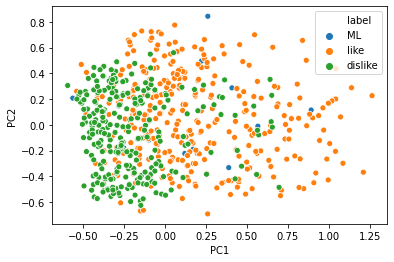

In [5]:
sns.scatterplot('PC1','PC2', data=all_to_score, hue='label')
plt.show()


In [6]:
# ML
clf = RandomForestClassifier(random_state=42)
clf.fit(playlist_data[use_clust].drop(['acousticness'], axis=1).values, 
        playlist_data['label'].values)
scores = pd.DataFrame(clf.predict_proba(ml_week_score[use_clust].drop(['acousticness'], axis=1)), 
                      ml_week_score.name, clf.classes_)
scalar_ = 10
scores = ((scores['like'] * scalar_) + 1).to_dict()
scores

/Users/cameronmartino/miniconda2/envs/qiime2-2019.7/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{"Last Year's Wife": 11.0,
 'Five Four You Are': 9.0,
 'Vacuum Cleaner': 9.0,
 'New Speedway Boogie': 11.0,
 'Sweetest Touch': 6.0,
 'California Hurricane': 11.0,
 'Undercover': 8.0,
 'Sneedville Blues': 11.0,
 "Not The Best I've Had, Actually": 7.0,
 'Penumbra': 6.0,
 'Seoul': 8.0,
 'Leah and I': 8.0}

# Normalize scores for voting system ($ \sum_{}^{}$down=-4, $ \sum_{}^{}$up=14)

In [7]:
# here is what I manually add to ML
res_score = ml_score(list(scores.values()))
res_score = {k:v for v, k in zip(res_score, scores.keys())}
res_score

{"Last Year's Wife": 2,
 'Five Four You Are': 2,
 'Vacuum Cleaner': 2,
 'New Speedway Boogie': 2,
 'Sweetest Touch': -1,
 'California Hurricane': 2,
 'Undercover': -1,
 'Sneedville Blues': 2,
 "Not The Best I've Had, Actually": -1,
 'Penumbra': -1,
 'Seoul': 1,
 'Leah and I': 1}